<a href="https://colab.research.google.com/github/harshini-15/Portfolio-Template/blob/main/BERT(EEG)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import numpy as np
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

#load the data in the dataframe
df=pd.read_csv("/content/drive/MyDrive/EEG_Bert/EEG(28) (1).csv")

In [5]:
# Convert categorical features to numerical format
df.replace({"Decreased": 1, "Increased": 0}, inplace=True)

# Concatenate the features into a single string
X = df[['Delta_Power', 'Theta_Power', 'Alpha_Power', 'Beta_Power', 'Gamma_Power']].astype(str).agg(' '.join, axis=1)

# Tokenize the input data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_encoded = tokenizer(X.tolist(), padding=True, truncation=True, return_tensors='pt')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded['input_ids'], df['Result'], test_size=0.3, random_state=42)
# Convert y_train to a PyTorch tensor and add a dimension
y_train_tensor = torch.tensor(y_train.values).unsqueeze(1)

# Define the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
model.train()
for epoch in range(50):
    optimizer.zero_grad()
    outputs = model(input_ids=X_train, labels=y_train_tensor)
    loss = outputs.loss
    loss.backward()
    optimizer.step()


# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(input_ids=X_test)
    predicted_labels = torch.argmax(outputs.logits, dim=1)
    accuracy = accuracy_score(y_test, predicted_labels)

print("Accuracy:", accuracy)


<ipython-input-5-71bd74c7ad91>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"Decreased": 1, "Increased": 0}, inplace=True)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 1.0


In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, predicted_labels))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         1

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



In [ ]:
cm = confusion_matrix(y_test, predicted_labels)
print(cm)

[[8 0]
 [0 1]]


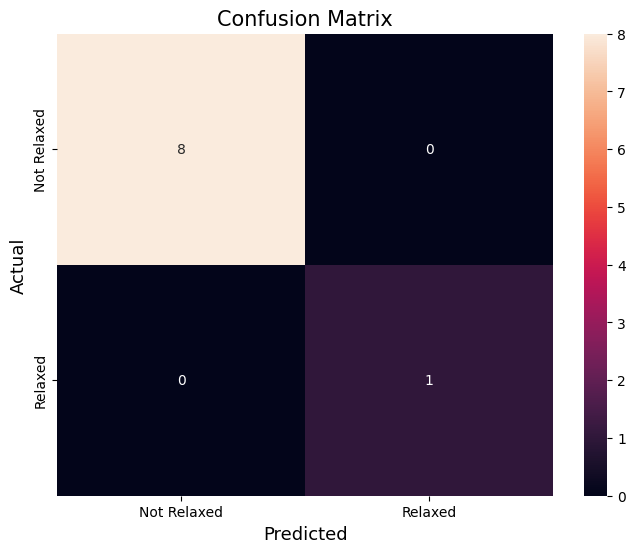

In [ ]:
import seaborn as sns

# Get the confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g',
            xticklabels=['Not Relaxed', 'Relaxed'],
            yticklabels=['Not Relaxed', 'Relaxed'])
plt.xlabel('Predicted',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=15)
plt.show()


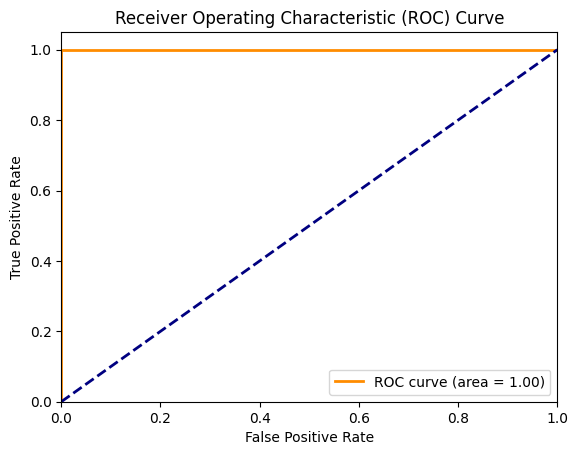

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predicted_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
